<a href="https://colab.research.google.com/github/ziatdinovmax/APS2020Tutorial/blob/master/APS2020_Unet_AtomicImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training deep learning model in PyTorch for "semantic" segmentation of atomic images

Created: February 2019

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com

---
This notebook demonstrates how to train a [U-Net](https://en.wikipedia.org/wiki/U-Net)-like fully convolutional neural network for a multi-class "semantic" segmentation of atomic images. We are going to use a training set prepared from a large (~3000 px x 3000 px) experimental scanning transmission electron microscopy image of BiFeO$_3$ with various distortions where every atom was "labeled" using the information about its (x, y) coordinates. [Here](https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_training_data.ipynb#scrollTo=C6_FS-KAEh9s) you can find a description of how the training set was generated. Alternatively, one can use simulated data. The goal is to train a neural network that could generalize and perform fast identification of atomic positions on various kind of images with different noise levels from the same (or similar) system.

**Note:** It is always a good idea to train your model on a diverse training set (e.g. many labeled expermental images, or simulated data for a variety of atomic structures/positions). Here we used a training set made from a single image just to show a *quick* example of how atomnet module works. Such a model will not generalize very well. 

---



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore", module="torch.nn.functional")

Define a helper function that set seeds for generating random numbers (for reproducibility):

In [0]:
def rng_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available(): # for GPU
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Download training data:

In [21]:
download_link = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
!gdown -q $download_link -O 'training_data-m.npy'
dataset = np.load('training_data-m.npy')
images_all = dataset['X_train']
labels_all = dataset['y_train']
images_test_all = dataset['X_test']
labels_test_all = dataset['y_test']
print(images_all.shape, labels_all.shape)

(1656, 1, 256, 256) (1656, 256, 256)


The training data is based on a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see *arXiv:2002.04245* and the associated notebook). The original image was ~3000 px x 3000 px. We randomly cropped about 2000 image-label pairs of 256 x 256 resolution and then applied different image "distortions" (noise, blurring, zoom, etc.) to each cropped image, treating two atomic sublattices as two different classes.  The training/test images and labels represent 4 separate numpy arrays with the dimensions ```(n_images, n_channels=1, image_height, image_width)``` for training/test images, and ```(n_images, image_height, image_width)``` for the associated labels. The reason that our images have 4 dimensions, while our labels have only three dimensions labels is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Basically, if you have multiple channels corresponding to different classes in your labeled data, you'll need to [map your target classes to tensor indices](https://discuss.pytorch.org/t/multi-class-cross-entropy-loss-function-implementation-in-pytorch/19077/20). Here, we already did this for our labeled data during the training data preparation stage and so everything is ready for training.

Plot some image-label pairs:

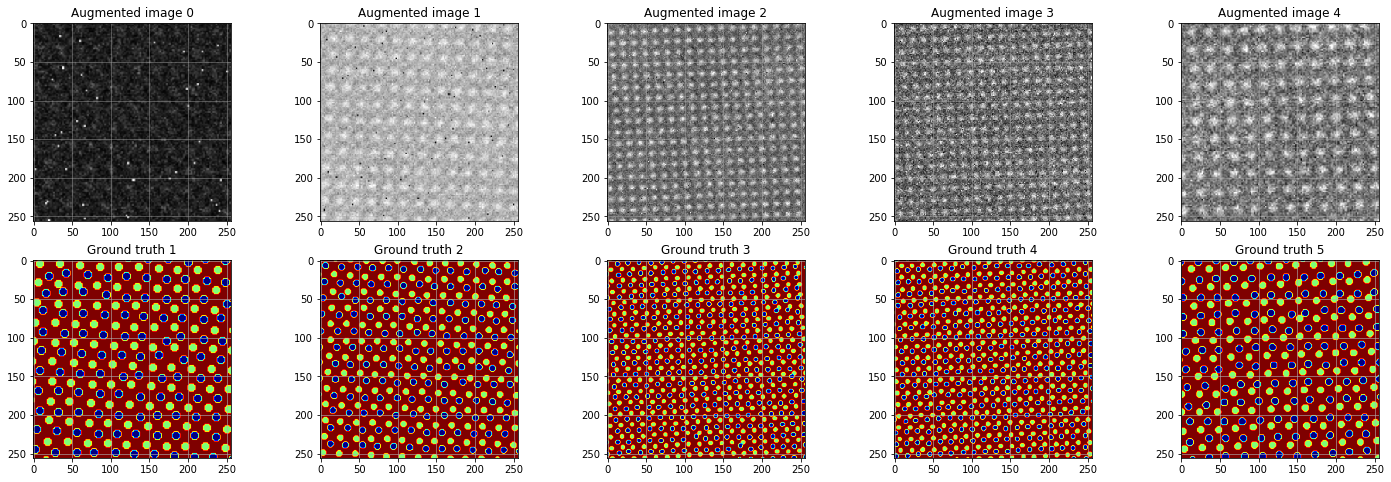

In [3]:
n = 5

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images_all[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels_all.shape[1] == 1:
        ax.imshow(labels_all[i-1, 0], cmap='jet', interpolation='Gaussian')
    else:
        ax.imshow(labels_all[i-1], cmap='jet', interpolation='Gaussian')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

Let's start constucting a deep fully convolutional neural network for "semantic" segmentation of atomic images. The neural network will be trained to take the images in the top row  (see plot above) as the input and to output clean images of "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms. 

First we write two classes that will define two major blocks of our neural network, namely, conv2dblock (convolutional layer followed by parametric ReLU activation with optional dropout (before activation) and/or batch normalization (after activation) layers) and upsample_block (upsampling either with a bilinear or nearest interpolation followed by one-by-one convolutional layer).

Notice that in PyTorch we have to specify number of input and outpur channels and take care of image size padding (we cannot just use padding = 'same' like we can do in e.g. Keras). This formula will be very useful:

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

o = output

p = padding

k = kernel_size

s = stride

d = dilation

Each block is defined in two steps. First, we specify model parameters (using ```__init__```), and then outline how they are applied to the inputs (using ```forward```).

In [0]:
class conv2dblock(nn.Module):
    '''
    Creates block(s) consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, nb_layers, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1, use_batchnorm=False,
                 lrelu_a=0.01, dropout_=0):
        '''Initializes module parameters'''
        super(conv2dblock, self).__init__()
        block = []
        for idx in range(nb_layers):
            input_channels = output_channels if idx > 0 else input_channels
            block.append(nn.Conv2d(input_channels,
                                   output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding))
            if dropout_ > 0:
                block.append(nn.Dropout(dropout_))
            block.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output


class upsample_block(nn.Module):
    '''
    Defines upsampling block. The upsampling is performed 
    using bilinear or nearest interpolation followed by 1-by-1
    convolution (the latter can be used to reduce
    a number of feature channels).
    '''
    def __init__(self,
                 input_channels,
                 output_channels,
                 scale_factor=2,
                 mode="bilinear"):
        '''Initializes module parameters'''
        super(upsample_block, self).__init__()
        assert mode == 'bilinear' or mode == 'nearest',\
            "use 'bilinear' or 'nearest' for upsampling mode"
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        '''Defines a forward path'''
        x = F.interpolate(
            x, scale_factor=self.scale_factor, mode=self.mode)
        return self.conv(x)

Now we create class atomUnet for constructing a neural network for "atomic segmentation". 

Now let's build our model. It will have a contracting path consisting of regular convolutional operations followed by max-pooling operation, a bottleneck layer with three layers of atrous convolutions with different dilation rates, and an expanding path with bilinear upsampling that has the same convolutional blocks as the contracting path but in a reversed order. The skip connections provide a flow of information between contracting and expanding pathes.The final layer provides a pixel-wise classification of the input data.

In [0]:
class smallUnet(nn.Module):
    '''
    Builds a fully convolutional Unet-like neural network model
    Args:
        nb_classes: int
            number of classes in the ground truth
        nb_filters: int
            number of filters in 1st convolutional block
            (gets multibplied by 2 in each next block)
        use_dropout: bool
            use / not use dropout in the 3 inner layers
        batch_norm: bool
            use / not use batch normalization after each convolutional layer
        upsampling mode: str
            "bilinear" or "nearest" upsampling method.
            Bilinear is usually more accurate,
            but adds additional (small) randomness;
            for full reproducibility, consider using 'nearest'
            (this assumes that all other sources of randomness are fixed)
    '''
    def __init__(self,
                 nb_classes=3,
                 nb_filters=16,
                 with_dilation=True,
                 use_dropout=False,
                 batch_norm=True,
                 upsampling_mode="nearest"):
        super(smallUnet, self).__init__()
        dropout_vals = [.1, .2, .1] if use_dropout else [0, 0, 0]
        self.c1 = conv2dblock(
            1, 1, nb_filters,
            use_batchnorm=batch_norm
        )
        self.c2 = conv2dblock(
            2, nb_filters, nb_filters*2,
            use_batchnorm=batch_norm
        )
        self.c3 = conv2dblock(
            2, nb_filters*2, nb_filters*4,
            use_batchnorm=batch_norm,
            dropout_=dropout_vals[0]
        )
        self.bn = conv2dblock(
            3, nb_filters*4, nb_filters*8,
            use_batchnorm=batch_norm,
            dropout_=dropout_vals[1]
        )
        self.upsample_block1 = upsample_block(
            nb_filters*8, nb_filters*4,
            mode=upsampling_mode)
        self.c4 = conv2dblock(
            2, nb_filters*8, nb_filters*4,
            use_batchnorm=batch_norm,
            dropout_=dropout_vals[2]
        )
        self.upsample_block2 = upsample_block(
            nb_filters*4, nb_filters*2,
            mode=upsampling_mode)
        self.c5 = conv2dblock(
            2, nb_filters*4, nb_filters*2,
            use_batchnorm=batch_norm
        )
        self.upsample_block3 = upsample_block(
            nb_filters*2, nb_filters,
            mode=upsampling_mode)
        self.c6 = conv2dblock(
            1, nb_filters*2, nb_filters,
            use_batchnorm=batch_norm
        )
        self.px = nn.Conv2d(nb_filters, nb_classes, 1, 1, 0)

    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Bottleneck layer
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # Final layer used for pixel-wise convolution
        px = self.px(u1)
        return px

We can also vizualize our model using torchviz:

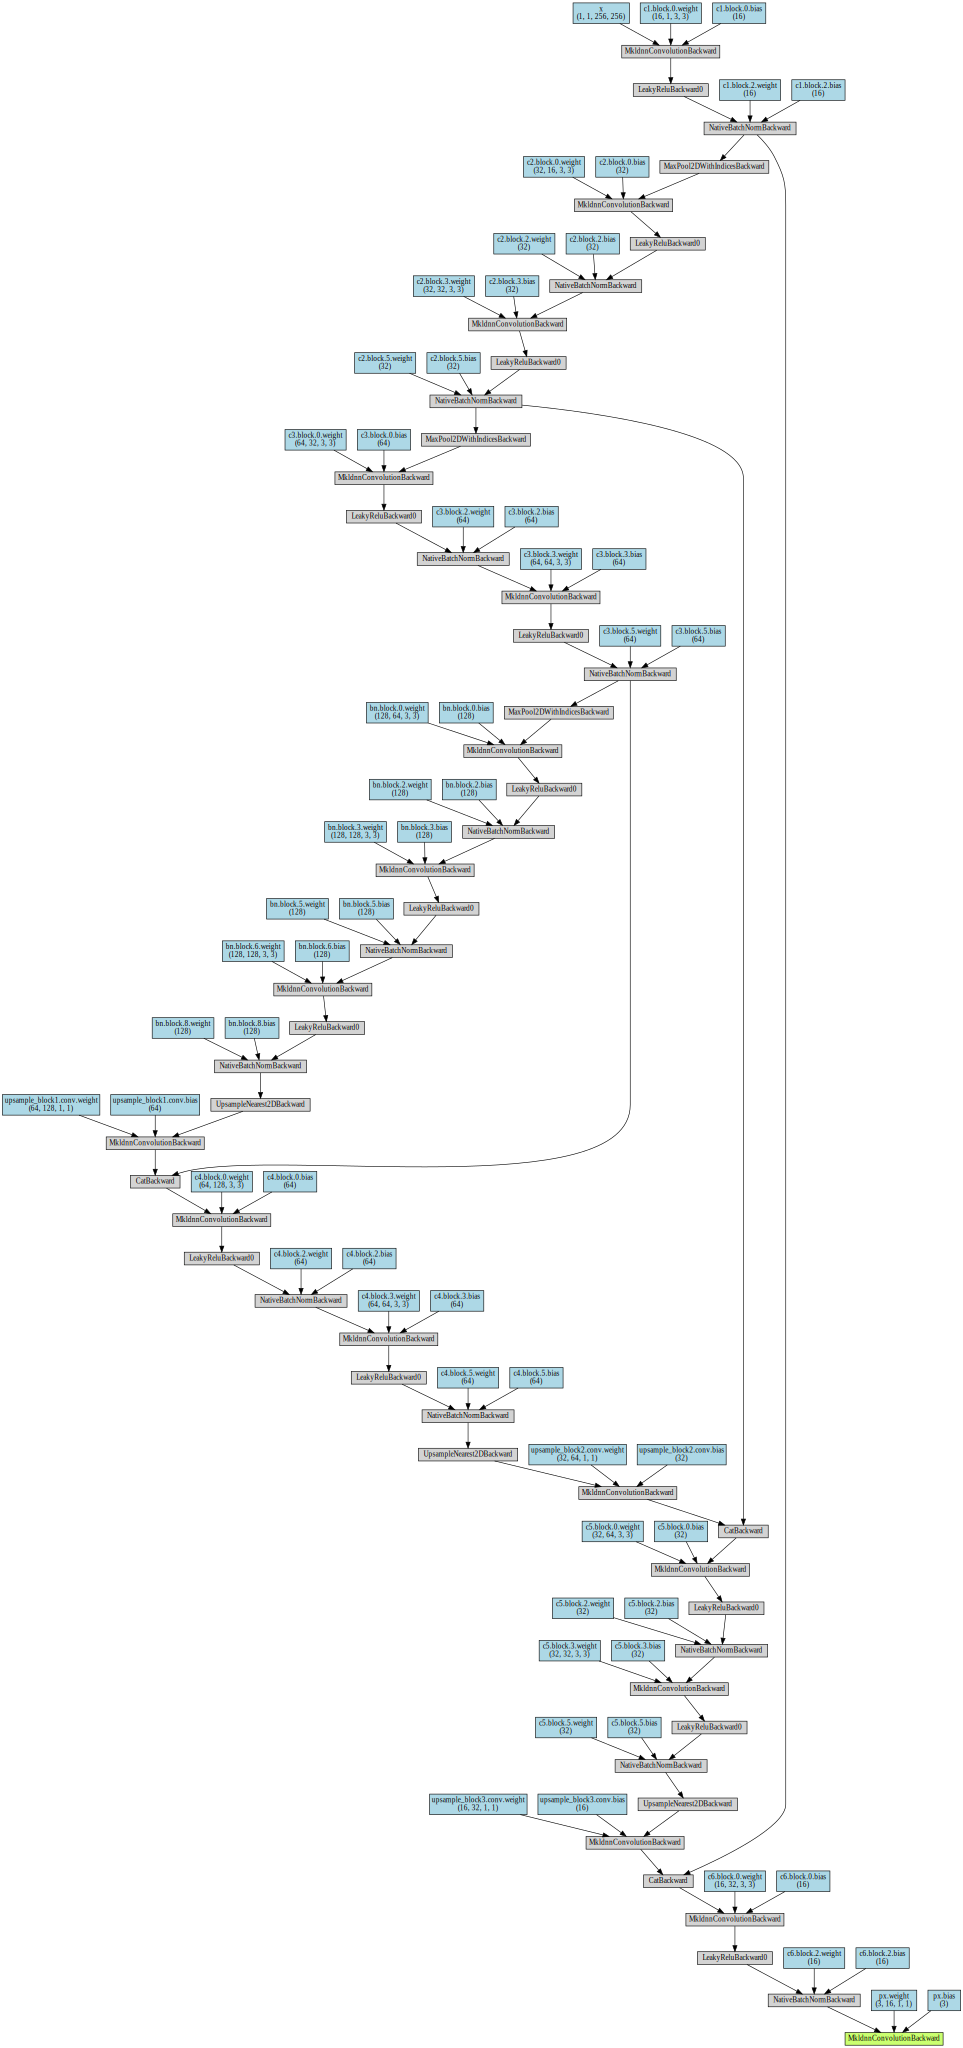

In [25]:
!pip install -q torchviz
from torchviz import make_dot

model = smallUnet()
x = torch.randn(1, 1, 256, 256).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Initialize our model, move it to GPU, and select weights optimizer and loss function:

In [0]:
rng_seed(1)

# Initialize a model
model = smallUnet()
# move our model to GPU
model.cuda()
# specify loss function
criterion = torch.nn.CrossEntropyLoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Specify basic parameters for training loop:

In [0]:
batch_size = 32 # number of images in one batch
epochs = 500 # Number of epochs (here 1 epoch == 1 batch)
print_loss = 100 # print loss every m-th epoch.
savedir = './' # dir to save results

Here we are going to feed one batch per epoch to our neural network during training (as opposed to feeding all the batches during a single epoch and then calculating the average loss). We therefore split our numpy arrays into 4 lists where each element is a numpy array with the selected above batch size.

In [0]:
n_train_batches, _ = np.divmod(labels_all.shape[0], batch_size)
n_test_batches, _ = np.divmod(labels_test_all.shape[0], batch_size)
images_all = np.split(
    images_all[:n_train_batches*batch_size], n_train_batches)
labels_all = np.split(
    labels_all[:n_train_batches*batch_size], n_train_batches)
images_test_all = np.split(
    images_test_all[:n_test_batches*batch_size], n_test_batches)
labels_test_all = np.split(
    labels_test_all[:n_test_batches*batch_size], n_test_batches)

Finally, we train our model:

In [30]:
# Generate sequence of random numbers for batch selection during training/testing
batch_ridx = [np.random.randint(0, len(images_all)) for _ in range(epochs)]
batch_ridx_t = [np.random.randint(0, len(images_test_all)) for _ in range(epochs)]
# Start training
train_losses, test_losses = [], []
for e in range(epochs):  
    model.train()
    # Generate batch of training images with corresponding ground truth
    images = images_all[batch_ridx[e]]
    labels = labels_all[batch_ridx[e]]
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).long()
    images, labels = images.cuda(), labels.cuda() 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Now test the current model state using test data
    model.eval()
    images_ = images_test_all[batch_ridx_t[e]]
    labels_ = labels_test_all[batch_ridx_t[e]]
    images_ = torch.from_numpy(images_).float()
    labels_ = torch.from_numpy(labels_).long()
    images_, labels_ = images_.cuda(), labels_.cuda()
    with torch.no_grad(): 
        prob = model.forward(images_)
        loss = criterion(prob, labels_)
        test_losses.append(loss.item())
    # Print statistics
    if e == 0 or (e+1) % print_loss == 0:
        print('Epoch {} .... Training loss: {} .... Test loss: {}'.format(
            e+1, np.around(train_losses[-1], 8), np.around(test_losses[-1], 8))
        )
    # Save the best model weights
    if e > 100 and test_losses[-1] < min(test_losses[: -1]):
        torch.save(model.state_dict(), 
                   os.path.join(savedir, 'smallUnet-1-best_weights.pt'))
# Save final weights
torch.save(model.state_dict(), 
           os.path.join(savedir, 'smallUnet-1-final_weights.pt'))

Epoch 1 .... Training loss: 1.27220535 .... Test loss: 1.21110785
Epoch 100 .... Training loss: 0.41351685 .... Test loss: 0.3911638
Epoch 200 .... Training loss: 0.27420327 .... Test loss: 0.25178549
Epoch 300 .... Training loss: 0.23466456 .... Test loss: 0.22391158
Epoch 400 .... Training loss: 0.20966542 .... Test loss: 0.23151663
Epoch 500 .... Training loss: 0.2040633 .... Test loss: 0.20648669


Plot training history:

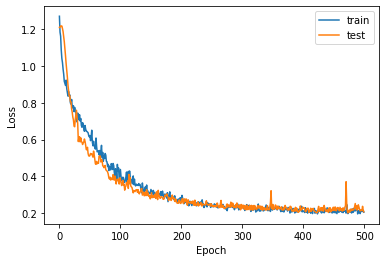

In [31]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Evaluate model performance on the test data:

Text(0.5, 1.0, 'Ground truth')

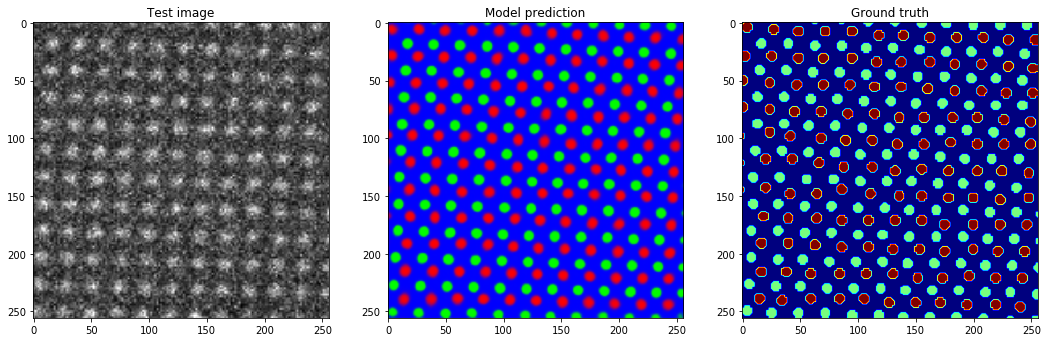

In [50]:
k, im = 6, 5 # batch, image
test_img = images_test_all[k][im]
test_lbl = labels_test_all[k][im]
# Convert to 4D tensor (required, even if it is a single image)
test_img = test_img[np.newaxis, ...]
# Convert to pytorch format and move to GPU
test_img_ = torch.from_numpy(test_img).float().cuda()
# make a prediction
prediction = model.forward(test_img_)
prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
prediction = np.transpose(prediction, [0, 2, 3, 1]) # rearange dimensions for plotting
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(test_img[0,0], cmap='gray')
ax2.imshow(prediction[0], Interpolation='Gaussian')
ax3.imshow(test_lbl, Interpolation='Gaussian', cmap='jet_r')
ax1.set_title('Test image')
ax2.set_title('Model prediction')
ax3.set_title('Ground truth')

We now have a multichannel output of a neural network where each channel corresponds to a different atomic class (+ background). In each channel, we have a set of blobs on a uniform background whose centers correspond to atomic centers (if the network was trained properly). What we have to do now is to convert pixel data from the network output into coordinate data. Below we define a class that will do it.

In [0]:
import cv2
from scipy import ndimage

class FindAtoms:
    '''
    Transforms pixel data from NN output into coordinate data
    '''
    def __init__(self, nn_output,
                 threshold=0.5, dist_edge=5,
                 dim_order='channel_last'):
        
        if nn_output.shape[-1] == 1: # Add background class for 1-channel data
            nn_output_b = 1 - nn_output
            nn_output = np.concatenate(
                (nn_output[:, :, :, None], nn_output_b[:, :, :, None]), axis=3)
        if dim_order == 'channel_first':  # make channel dim the last dim
            nn_output = np.transpose(nn_output, (0, 2, 3, 1))
        elif dim_order == 'channel_last':
            pass
        else:
            raise NotImplementedError(
                'For dim_order, use "channel_first" (e.g. pytorch)',
                 'or "channel_last" (e.g. tensorflow)')
        self.nn_output = nn_output
        self.threshold = threshold
        self.dist_edge = dist_edge
                       
    def get_all_coordinates(self):
        '''Extract all atomic coordinates in image
        via CoM method & store data as a dictionary
        (key: frame number)'''
        
        def find_com(image_data):
            '''Find atoms via center of mass methods'''
            labels, nlabels = ndimage.label(image_data)
            coordinates = np.array(
                ndimage.center_of_mass(
                    image_data, labels, np.arange(nlabels) + 1))
            coordinates = coordinates.reshape(coordinates.shape[0], 2)
            return coordinates

        d_coord = {}
        for i, decoded_img in enumerate(self.nn_output):
            coordinates = np.empty((0, 2))
            category = np.empty((0, 1))
            # we assume that class backgrpund is always the last one
            for ch in range(decoded_img.shape[2]-1):
                _, decoded_img_c = cv2.threshold(
                    decoded_img[:, :, ch], self.threshold, 1, cv2.THRESH_BINARY)
                coord = find_com(decoded_img_c)
                coord_ch = self.rem_edge_coord(coord)
                category_ch = np.zeros((coord_ch.shape[0], 1)) + ch
                coordinates = np.append(coordinates, coord_ch, axis=0)
                category = np.append(category, category_ch, axis=0)
            d_coord[i] = np.concatenate((coordinates, category), axis=1)
        return d_coord

    def rem_edge_coord(self, coordinates):
        '''Remove coordinates at the image edges'''

        def coord_edges(coordinates, w, h):
            return [coordinates[0] > w - self.dist_edge,
                    coordinates[0] < self.dist_edge,
                    coordinates[1] > h - self.dist_edge,
                    coordinates[1] < self.dist_edge]

        w, h = self.nn_output.shape[1:3]
        coord_to_rem = [
                        idx for idx, c in enumerate(coordinates) 
                        if any(coord_edges(c, w, h))
                        ]
        coord_to_rem = np.array(coord_to_rem, dtype=int)
        coordinates = np.delete(coordinates, coord_to_rem, axis=0)
        return coordinates

Let's now transform our NN prediction on a test image to coordinates:

In [0]:
coordinates = FindAtoms(prediction).get_all_coordinates()

Plot results:

Text(0.5, 1.0, 'Test data + predicted coordinates')

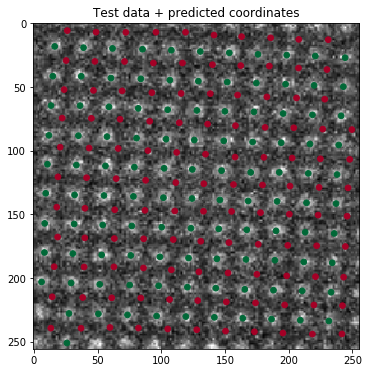

In [81]:
y, x, c = coordinates[0].T
plt.figure(figsize=(6, 6))
plt.imshow(test_img[0,0], cmap='gray')
plt.scatter(x, y, c=c, cmap='RdYlGn', s=32);
plt.title('Test data + predicted coordinates')

Now let's apply the trained model to experimental image from a diferent but similar system. The experimental image was obtained on LBFO system by Chris Nelson (CNMS ORNL) and published earlier in *Applied Physics Letters 115, 052902 (2019)*. 

In [0]:
# Load experimental data
!!gdown -q https://drive.google.com/uc?id=1hdWfUdKFNLIEbadLpKFnEgEVF8KX1ANr
expdata = np.load('lbfo_expdata.npy')
# Convert to 4D tensor (required, even if it is a single image)
expdata = expdata[None, None, ...]
# Convert to pytorch format and move to GPU
expdata_ = torch.from_numpy(expdata).float().cuda()
# make a prediction
prediction = model.forward(expdata_)
prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
prediction = np.transpose(prediction, [0, 2, 3, 1])
# get coordinates
coordinates_e = FindAtoms(prediction).get_all_coordinates()

Plot results:

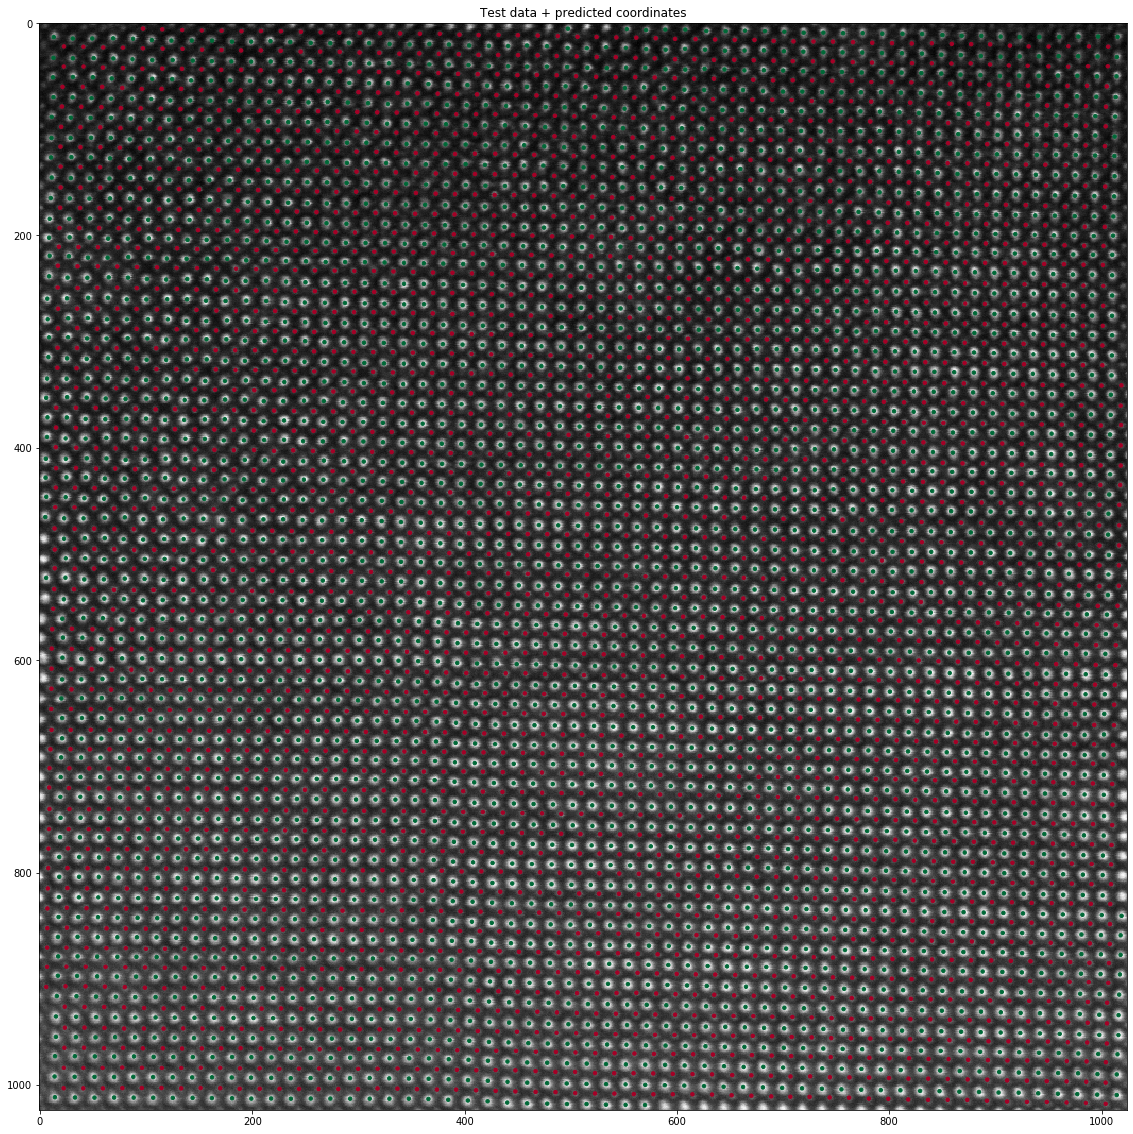

In [82]:
y, x, c = coordinates_e[0].T
plt.figure(figsize=(20, 20))
plt.imshow(expdata[0,0], cmap='gray')
plt.scatter(x, y, c=c, cmap='RdYlGn', s=12)
plt.title('Test data + predicted coordinates');

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can sometimes compare our results with the results of other methods.

Once we have all atomic coordiantes and "cleaned" images we can perform various forms of analysis on local image descriptors. See the example [here](https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomstat.ipynb). Please also check out the [AtomAI](https://github.com/ziatdinovmax/atomai) project that aims at simplifying the way of training and applying neural networks for microscopy data.